<a href="https://colab.research.google.com/github/Sergey7OV/CompoZit/blob/main/VKR_nero_mn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нейронная сеть для предсказания соотношения матрица-наполнитель

In [1]:
#Импортируем библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LeakyReLU, Activation, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
#Cмонтируем весь Google Disk в Colab:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Загружаем объединенный, очищенный и нормализорванный датасет
df_norm = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/ВКР/data/X_sum_norm.xlsx')
#Удаляем лишний столбец
df_norm = df_norm.drop(columns='Unnamed: 0')

#Загружаем объединенный датасет
df = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/ВКР/data/X_sum.xlsx")
#Удаляем лишний столбец
df = df.drop(columns='Unnamed: 0')

#Разделяем датасет на зависимые и независимые переменные
X_mn = df_norm.drop(['Соотношение матрица-наполнитель'], axis=1)
y_mn = df_norm[['Соотношение матрица-наполнитель']]

#Разделяем зависимые и независимые переменные на тренировочую и тестирующую выборку
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(X_mn, y_mn, test_size=0.3, random_state=1)

print ('Тренировочная часть для Модуля упругости при растяжении: %d строк\nТестовая часть для Модуля упругости при растяжении:    : %d строк' % (X_train_mn.shape[0], X_test_mn.shape[0]))
print ('Тренировочная часть для Прочности при растяжении: %d строк\nТестовая часть для Прочности при растяжении    : %d строк' % (X_train_mn.shape[0], X_test_mn.shape[0]))


Тренировочная часть для Модуля упругости при растяжении: 645 строк
Тестовая часть для Модуля упругости при растяжении:    : 277 строк
Тренировочная часть для Прочности при растяжении: 645 строк
Тестовая часть для Прочности при растяжении    : 277 строк


In [5]:
df_norm.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,Угол нашивки
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,0.499412,0.502904,0.451341,0.506200,0.490578,0.516739,0.373295,0.487343,0.503776,0.507876,0.503426,0.503938,0.510846
std,0.187858,0.188395,0.201534,0.186876,0.180548,0.190721,0.217269,0.196366,0.188668,0.199418,0.183587,0.193933,0.500154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.371909,0.368184,0.305188,0.378514,0.366571,0.386228,0.204335,0.353512,0.373447,0.374647,0.372844,0.376869,0.000000
50%,0.495189,0.511396,0.451377,0.506382,0.488852,0.516931,0.354161,0.483718,0.501481,0.510143,0.506414,0.504310,1.000000
75%,0.629774,0.624719,0.587193,0.638735,0.623046,0.646553,0.538397,0.617568,0.624299,0.642511,0.626112,0.630842,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 16)                208       
                                                                 
 dropout_38 (Dropout)        (None, 16)                0         
                                                                 
 dense_115 (Dense)           (None, 32)                544       
                                                                 
 dense_116 (Dense)           (None, 1)                 33        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
19/19 - 1s - loss: 1.9345 - mae: 1.3768 - val_loss: 1.6823 - val_mae: 1.2821 - 922ms/epoch - 49ms/step
Epoch 2/100
19/19 - 0s - loss: 1.2165 - mae: 1.0760 - val_loss: 0.6034 -

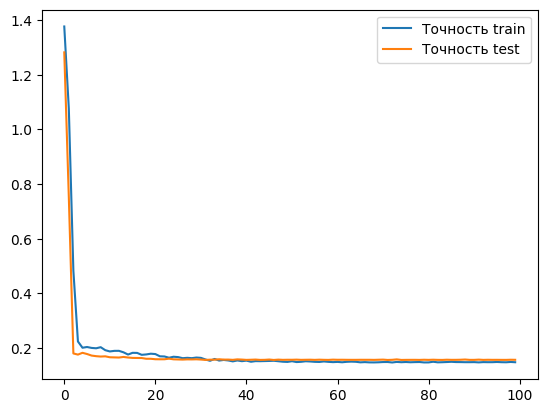

In [62]:
# модель полносвязной нейронной сети для целевого параметра y1
model_y1 = Sequential()
model_y1.add(Dense(16,  input_dim=12, activation = 'sigmoid'))
model_y1.add(Dropout(0.5))
model_y1.add(Dense(32, activation = 'sigmoid'))
model_y1.add(Dense(1, activation = 'tanh'))
model_y1.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y1.summary()
history = model_y1.fit(X_train_mn, y_train_mn, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 32)                416       
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_110 (Dense)           (None, 64)                2112      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_111 (Dense)           (None, 32)                2080      
                                                                 
 dense_112 (Dense)           (None, 16)                528       
                                                                 
 dense_113 (Dense)           (None, 1)               

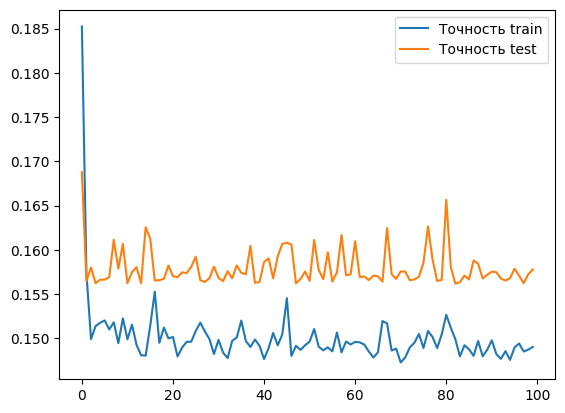

In [61]:
# модель полносвязной нейронной сети тренируем на нормализованных данных
model_y2 = Sequential([
                Dense(32,  input_dim=12, activation = 'sigmoid'),
                Dropout(0.5),
                Dense(64, activation = 'sigmoid'),
                Dropout(0.5),
                Dense(32, activation = 'sigmoid'),
                Dense(16, activation = 'sigmoid'),
                Dense(1, activation = 'linear')])
model_y2.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y2.summary()
history = model_y2.fit(X_train_mn,y_train_mn, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('MAE')
plt.legend()
plt.show()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 64)                832       
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_107 (Dense)           (None, 16)                528       
                                                                 
 dense_108 (Dense)           (None, 1)                 17        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-train

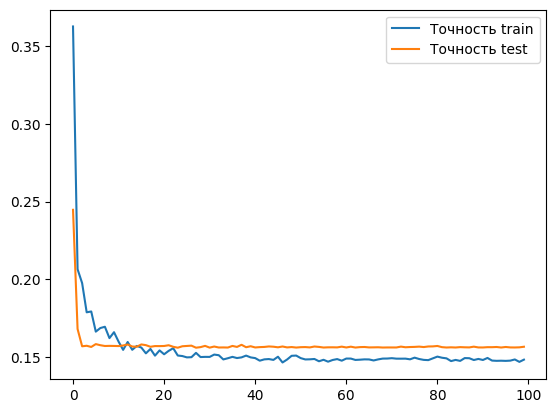

In [60]:
# модель полносвязной нейронной сети для целевого параметра y4 тренируем на нормализованных данных
model_y3 = Sequential()
model_y3.add(Dense(64,  input_dim=12, activation = 'sigmoid'))
model_y3.add(Dropout(0.5))
model_y3.add(Dense(32, activation = 'sigmoid'))
model_y3.add(Dropout(0.5))
model_y3.add(Dense(16, activation = 'sigmoid'))
model_y3.add(Dense(1, activation = 'tanh'))
model_y3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y3.summary()
history = model_y3.fit(X_train_mn,y_train_mn, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 100)               1300      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_102 (Dense)           (None, 50)                5050      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 50)                0         
                                                                 
 dense_103 (Dense)           (None, 1)                 51        
                                                                 
 dense_104 (Dense)           (None, 1)                 2         
                                                                 
Total params: 6,403
Trainable params: 6,403
Non-train

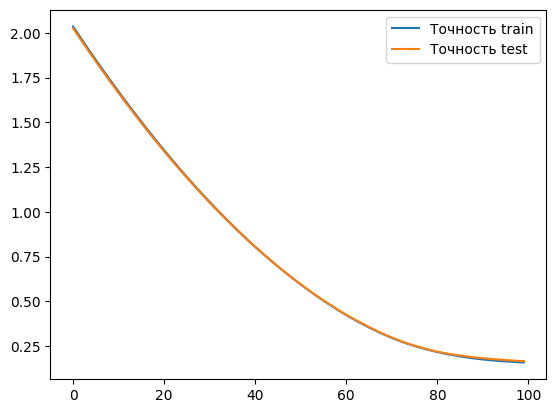

In [59]:
# модель полносвязной нейронной сети для целевого параметра y5 тренируем на нормализованных данных
model_y4= Sequential()
model_y4.add(Dense(100, input_dim=12, activation='sigmoid'))
model_y4.add(LeakyReLU(alpha=1.0))
model_y4.add(Dense(50, activation='sigmoid'))
model_y4.add(LeakyReLU(alpha=1.0))
model_y4.add(Dense(1, activation='softmax'))
model_y4.add(Dense(1, activation='linear'))
model_y4.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y4.summary()
history = model_y4.fit(X_train_mn,y_train_mn, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 100)               1300      
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_118 (Dense)           (None, 50)                5050      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 50)                0         
                                                                 
 dense_119 (Dense)           (None, 25)                1275      
                                                                 
 dense_120 (Dense)           (None, 1)               

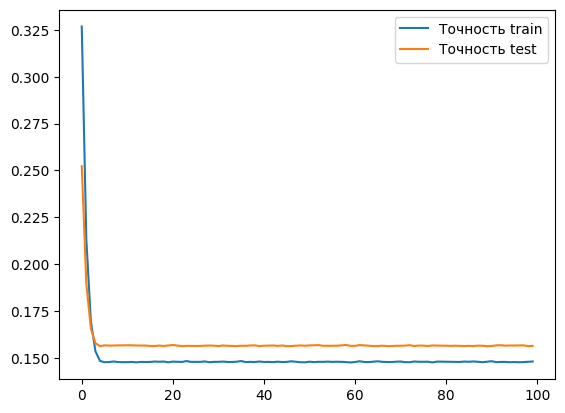

In [63]:
# модель полносвязной нейронной сети для целевого параметра y6 тренируем на нормализованных данных
model_y5= Sequential()
model_y5.add(Dense(100, input_dim=12, activation='sigmoid'))
model_y5.add(Dropout(0.5))
model_y5.add(LeakyReLU(alpha=1.0))
model_y5.add(Dense(50, activation='sigmoid'))
model_y5.add(LeakyReLU(alpha=1.0))
model_y5.add(Dense(25, activation='softmax'))
model_y5.add(Dense(1, activation='linear'))
model_y5.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y5.summary()
history = model_y5.fit(X_train_mn,y_train_mn, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)
plt.plot(history.history['mae'], label = 'Точность train')
plt.plot(history.history['val_mae'], label = 'Точность test')
plt.xlabel = ('Epochs')
plt.ylabel = ('mae')
plt.legend()
plt.show()

In [73]:
y_pred_1 = model_y1.predict(X_test_mn)
y_pred_2 = model_y2.predict(X_test_mn)
y_pred_3 = model_y3.predict(X_test_mn)
y_pred_4 = model_y4.predict(X_test_mn)
y_pred_5 = model_y5.predict(X_test_mn)


MAE_1 = mean_absolute_error(y_test_mn,y_pred_1)
MAE_2 = mean_absolute_error(y_test_mn,y_pred_2)
MAE_3 = mean_absolute_error(y_test_mn,y_pred_3)
MAE_4 = mean_absolute_error(y_test_mn,y_pred_4)
MAE_5 = mean_absolute_error(y_test_mn,y_pred_5)


MSE_1 = mean_squared_error(y_test_mn,y_pred_1)
MSE_2 = mean_squared_error(y_test_mn,y_pred_2)
MSE_3 = mean_squared_error(y_test_mn,y_pred_3)
MSE_4 = mean_squared_error(y_test_mn,y_pred_4)
MSE_5 = mean_squared_error(y_test_mn,y_pred_5)

R2_1 = r2_score(y_test_mn,y_pred_1)
R2_2 = r2_score(y_test_mn,y_pred_2)
R2_3 = r2_score(y_test_mn,y_pred_3)
R2_4 = r2_score(y_test_mn,y_pred_4)
R2_5 = r2_score(y_test_mn,y_pred_5)


ERR = []

ERR.append(['Нейросеть 1 ',MAE_1, MSE_1, R2_1])
ERR.append(['Нейросеть 2 ',MAE_2, MSE_2, R2_2])
ERR.append(['Нейросеть 3 ',MAE_3, MSE_3, R2_3])
ERR.append(['Нейросеть 4 ',MAE_4, MSE_4, R2_4])
ERR.append(['Нейросеть 5 ',MAE_5, MSE_5, R2_5])

ERR

9/9 [==============================] - 0s 5ms/step


[['Нейросеть 1 ',
  0.15617427623257507,
  0.037204866305288825,
  -0.001247942991688289],
 ['Нейросеть 2 ',
  0.1577630915770674,
  0.037468339572840154,
  -0.008338468865492388],
 ['Нейросеть 3 ',
  0.15488497272542256,
  0.037296911398320226,
  -0.0037250372326391723],
 ['Нейросеть 4 ',
  0.16182539498664764,
  0.04181927417240977,
  -0.1254297192993412],
 ['Нейросеть 5 ',
  0.15555790582130452,
  0.03715067493023215,
  0.0002104415744100807]]

9/9 [==============================] - 0s 2ms/step


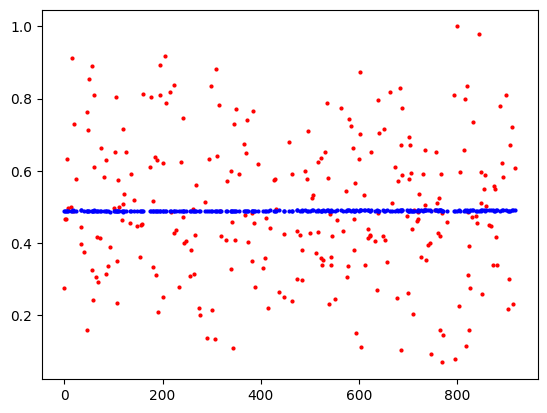

In [65]:
# Визуализация разброса предсказанных данных и тестовых данных
pred_1 = model_y1.predict(np.array((X_test_mn)))
plt.scatter(y_test_mn.index, y_test_mn, c = 'r', s = 4)
plt.scatter(y_test_mn.index, pred_0, c = 'b', s = 4)

9/9 [==============================] - 0s 2ms/step


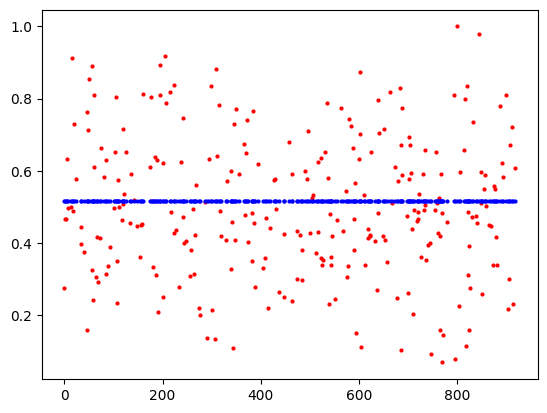

In [66]:
# Визуализация разброса предсказанных данных и тестовых данных
pred_2 = model_y2.predict(np.array((X_test_mn)))
plt.scatter(y_test_mn.index, y_test_mn, c = 'r', s = 4)
plt.scatter(y_test_mn.index, pred_2, c = 'b', s = 4)

9/9 [==============================] - 0s 2ms/step


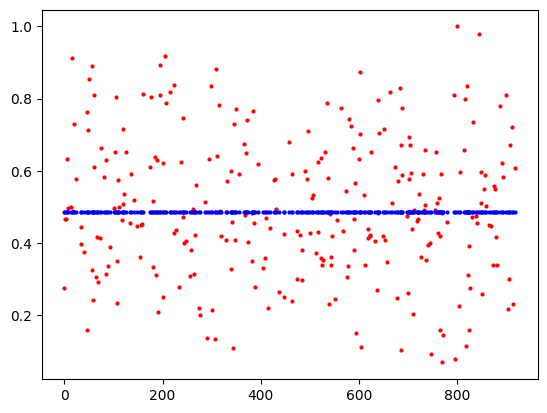

In [67]:
# Визуализация разброса предсказанных данных и тестовых данных
pred_3 = model_y3.predict(np.array((X_test_mn)))
plt.scatter(y_test_mn.index, y_test_mn, c = 'r', s = 4)
plt.scatter(y_test_mn.index, pred_3, c = 'b', s = 4)

9/9 [==============================] - 0s 2ms/step


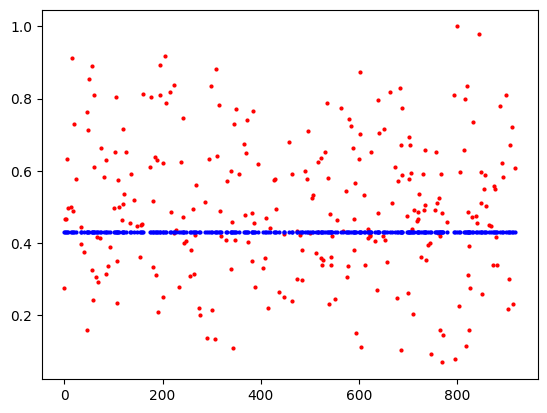

In [68]:
# Визуализация разброса предсказанных данных и тестовых данных
pred_4 = model_y4.predict(np.array((X_test_mn)))
plt.scatter(y_test_mn.index, y_test_mn, c = 'r', s = 4)
plt.scatter(y_test_mn.index, pred_4, c = 'b', s = 4)

9/9 [==============================] - 0s 2ms/step


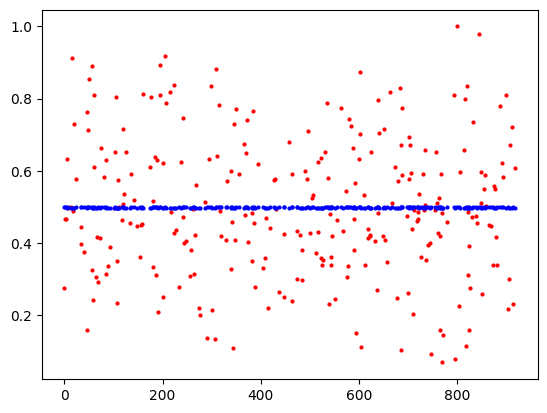

In [69]:
# Визуализация разброса предсказанных данных и тестовых данных
pred_5 = model_y5.predict(np.array((X_test_mn)))
plt.scatter(y_test_mn.index, y_test_mn, c = 'r', s = 4)
plt.scatter(y_test_mn.index, pred_5, c = 'b', s = 4)

In [ ]:
#Сохраним модель
with open('/content/gdrive/MyDrive/Colab Notebooks/ВКР/nero_nm_pkl.pkl', 'wb') as nero_nm:
  pickle.dump(model_mn, nero_nm)

In [ ]:
#Загрузим модель
with open('/content/gdrive/MyDrive/Colab Notebooks/ВКР/nero_nm_pkl.pkl', 'rb') as nero_nm:
  load_model = pickle.load(nero_nm)

In [ ]:
X_frame_1 = X_test_mn[0:1]
X_frame_1

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,Угол нашивки
827,0.554733,0.06155,0.72736,0.637922,0.849159,0.019718,0.56848,0.353659,0.485873,0.490829,0.561927,1


In [ ]:
y_predict_1 = load_model.predict(X_frame_1)
y_predict_1

1/1 [==============================] - 0s 24ms/step


array([[0.25914878]], dtype=float32)

In [ ]:
#Инвертирование значений из нормализованных
#Создаем ненормализованные значения 'Модуль упругости при растяжении, ГПа'
y_nonnorm_1 = df[['Соотношение матрица-наполнитель']]
min_max_scaler_1 = MinMaxScaler()
#Нормализуем значения с помощью MinMaxScaler
df_y = pd.DataFrame(min_max_scaler_1.fit_transform(y_nonnorm_1))
#Инвертируем нормализованное предсказанное значение
y_predict_nonnorm1 = min_max_scaler_1.inverse_transform(y_predict_1)
y_predict_nonnorm1

array([[1.7375824]], dtype=float32)

In [ ]:
#Сохраняем модель нейросети
model_mn.save('/content/gdrive/MyDrive/Colab Notebooks/ВКР/model_nero')

In [ ]:
#Выгрузка модели
model_load = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/ВКР/model_nero')

In [ ]:
y_predict_2 = model_load.predict(X_frame_1)
y_predict_2

1/1 [==============================] - 0s 108ms/step


array([[0.25914878]], dtype=float32)

In [ ]:
#Инвертирование значений из нормализованных
#Создаем ненормализованные значения 'Модуль упругости при растяжении, ГПа'
y_nonnorm_1 = df[['Соотношение матрица-наполнитель']]
min_max_scaler_1 = MinMaxScaler()
#Нормализуем значения с помощью MinMaxScaler
df_y = pd.DataFrame(min_max_scaler_1.fit_transform(y_nonnorm_1))
#Инвертируем нормализованное предсказанное значение
y_predict_nonnorm1 = min_max_scaler_1.inverse_transform(y_predict_1)
y_predict_nonnorm1

array([[1.7375824]], dtype=float32)